In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import  numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

df_tracks = pd.read_csv('MyData/output/tracks_metal.csv').dropna()
df_tracks = df_tracks[df_tracks["count"] > 3]
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 7 to 749
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artistName        141 non-null    object 
 1   trackName         141 non-null    object 
 2   sPlayed           141 non-null    int64  
 3   count             141 non-null    int64  
 4   genres            141 non-null    object 
 5   trackId           141 non-null    object 
 6   duration          141 non-null    float64
 7   danceability      141 non-null    float64
 8   acousticness      141 non-null    float64
 9   energy            141 non-null    float64
 10  instrumentalness  141 non-null    float64
 11  liveness          141 non-null    float64
 12  valence           141 non-null    float64
 13  loudness          141 non-null    float64
 14  speechiness       141 non-null    float64
 15  tempo             141 non-null    float64
 16  key               141 non-null    float64
 1

### Features
Features (9): danceability, acousticness, energy, instrumentalness, liveness,   valence, loudness, speechiness, tempo

## Value distribution of features

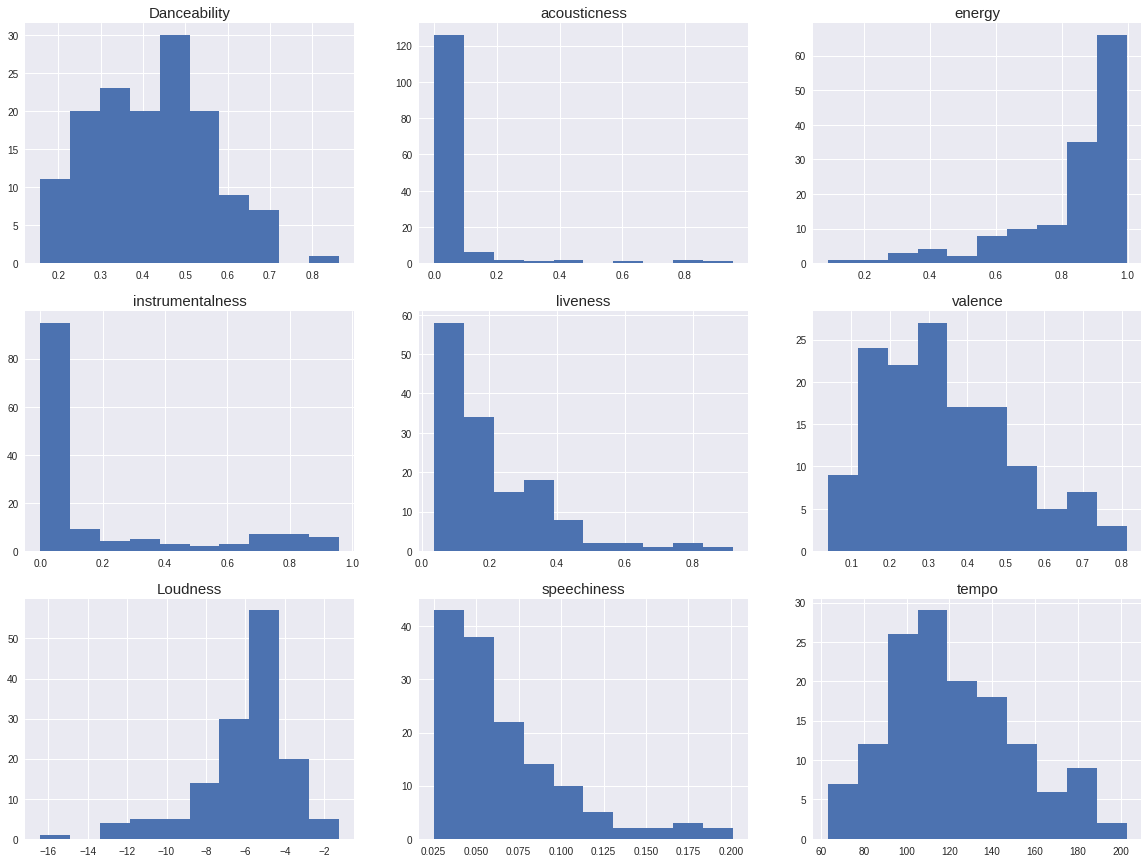

In [9]:
fig,axes = plt.subplots(3,3,figsize=(20,15))

axes[0,0].hist(df_tracks['danceability'])
axes[0,0].set_title('Danceability',fontsize=15)
axes[0,1].hist(df_tracks['acousticness'])
axes[0,1].set_title('acousticness',fontsize=15)
axes[0,2].hist(df_tracks['energy'])
axes[0,2].set_title('energy',fontsize=15)
axes[1,0].hist(df_tracks['instrumentalness'])
axes[1,0].set_title('instrumentalness',fontsize=15)
axes[1,1].hist(df_tracks['liveness'])
axes[1,1].set_title('liveness',fontsize=15)
axes[1,2].hist(df_tracks['valence'])
axes[1,2].set_title('valence',fontsize=15)
axes[2,0].hist(df_tracks['loudness'])
axes[2,0].set_title('Loudness',fontsize=15)
axes[2,1].hist(df_tracks['speechiness'])
axes[2,1].set_title('speechiness',fontsize=15)
axes[2,2].hist(df_tracks['tempo'])
axes[2,2].set_title('tempo',fontsize=15)
plt.show()

# Principal component analysis (PCA)

PCA on all features

In [10]:
df_pca = df_tracks[["danceability", "energy",  "speechiness", "liveness", "valence", "loudness","acousticness", "instrumentalness", "tempo"]].dropna()
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(df_pca)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_features)
print(pca.components_)
print(pca.explained_variance_)

[[ 0.22624188 -0.55882116 -0.33362862 -0.20730201  0.02530804 -0.4974386
   0.4606546  -0.03432921 -0.14416839]
 [ 0.59224322  0.1686665  -0.32743267 -0.15212757  0.61031473  0.19441487
  -0.25143682 -0.09067594 -0.09338533]]
[2.73690234 1.47876528]


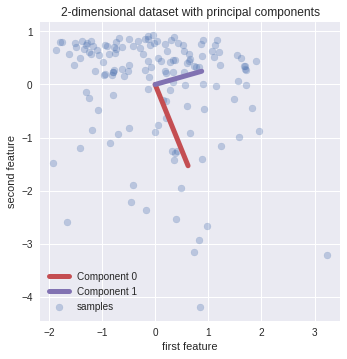

In [11]:
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

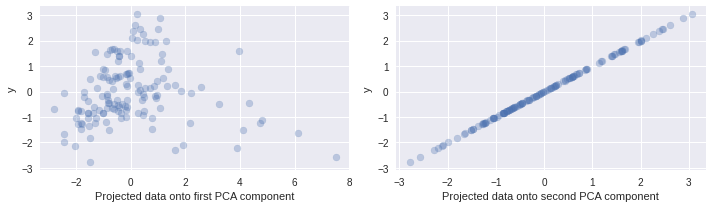

In [12]:
y = scaled_features.dot(pca.components_[1]) 

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(scaled_features.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel='Projected data onto first PCA component', ylabel='y')
axes[1].scatter(scaled_features.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel='Projected data onto second PCA component', ylabel='y')
plt.tight_layout()
plt.show()

PCA on only three features : danceability, energy, speechiness

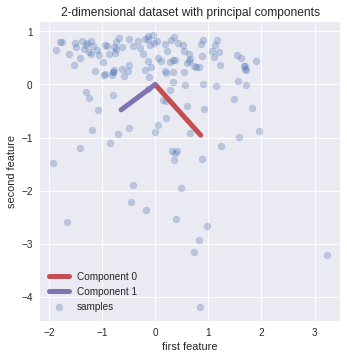

In [13]:
features = df_tracks[["danceability", "energy", "speechiness"]].dropna()
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(features)

pca = decomposition.PCA(n_components=2)
pca.fit(scaled_features)

plt.scatter(scaled_features[:, 0], scaled_features[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

The PCA does not show strong direction. 
I need to try non negative matrix factorization with some features.

In [14]:
# k-means with centered featuress
scaler = StandardScaler(with_mean=True, with_std=False)
centered_features = scaler.fit_transform(features)
kmeans = KMeans(init="k-means++",n_clusters=2,random_state=15).fit(centered_features)
df_tracks['kmeans'] = kmeans.labels_


Creation of 2 cluster with 3 features : energy, danceability, tempo.

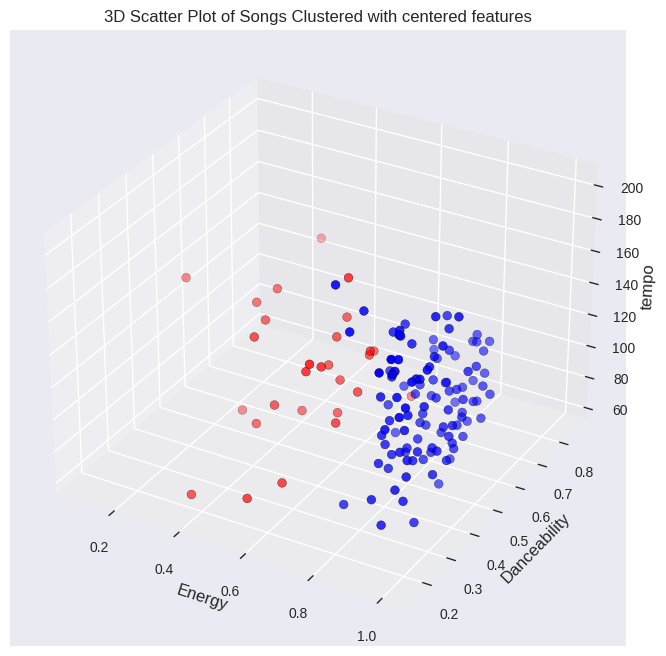

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

x = df_tracks['energy']
y = df_tracks['danceability']
z = df_tracks['tempo']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df_tracks['kmeans'],s=40,cmap=cmhot, edgecolor="black")
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('tempo',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered with centered features")
plt.show()

Creation of 4 cluster with 3 features : energy, danceability, tempo.

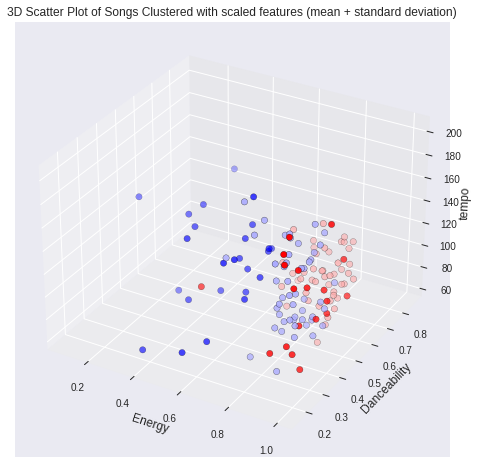

In [15]:
# k-means with scaled featuress
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_features = scaler.fit_transform(features)
kmeans = KMeans(init="k-means++",n_clusters=4,random_state=15).fit(scaled_features)
df_tracks['kmeans'] = kmeans.labels_
fig = plt.figure(figsize=(10,8)
                )
ax = fig.add_subplot(111,projection='3d')

x = df_tracks['energy']
y = df_tracks['danceability']
z = df_tracks['tempo']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=df_tracks['kmeans'],s=40,cmap=cmhot, edgecolor="black")
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('tempo',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered with scaled features (mean + standard deviation)")
plt.show()

In [9]:
#cluster_0 = df_tracks[df_tracks['kmeans']==0]
#cluster_1 = df_tracks[df_tracks['kmeans']==1]
#cluster_2 = df_tracks[df_tracks['kmeans']==2]
#cluster_3 = df_tracks[df_tracks['kmeans']==3]

#cluster_0.to_csv("MyData/output/cluster0.csv",index=False)
#cluster_1.to_csv("MyData/output/cluster1.csv",index=False)
#cluster_2.to_csv("MyData/output/cluster2.csv",index=False)
#cluster_3.to_csv("MyData/output/cluster3.csv",index=False)